In [ ]:
import os
import json

# Define the root directory and the datasets of interest
root_dir = 'evaluations'
datasets = ['vqa-v2', 'text-vqa', 'gqa']

# Initialize the result dictionary
result = {}

# Iterate through each model folder under the root directory
for model_name in os.listdir(root_dir):
    model_path = os.path.join(root_dir, model_name)
    if os.path.isdir(model_path):
        model_result = {}
        
        # Iterate through each dataset folder under the model folder
        for dataset in datasets:
            dataset_path = os.path.join(model_path, dataset)
            if os.path.isdir(dataset_path):
                # Determine the specific path to metrics.json based on the dataset
                if dataset == 'vqa-v2':
                    metrics_path = os.path.join(dataset_path, 'vqa-v2-slim', 'prism-clip+7b', 'metrics.json')
                elif dataset == 'text-vqa':
                    metrics_path = os.path.join(dataset_path, 'text-vqa-slim', 'prism-clip+7b', 'metrics.json')
                elif dataset == 'gqa':
                    metrics_path = os.path.join(dataset_path, 'gqa-slim', 'prism-clip+7b', 'metrics.json')
                
                # Parse the metrics.json file
                if os.path.isfile(metrics_path):
                    with open(metrics_path, 'r') as f:
                        metrics = json.load(f)
                        summary = metrics.get('summary', {})
                        
                        # Capture accuracies based on the dataset
                        if dataset == 'vqa-v2':
                            accuracy = summary.get('accuracy')
                            if accuracy is not None:
                                model_result['vqa-v2'] = accuracy
                        elif dataset == 'text-vqa':
                            ocr_accuracy = summary.get('accuracy__TextVQA-OCR')
                            pure_accuracy = summary.get('accuracy__TextVQA-Pure')
                            if ocr_accuracy is not None:
                                model_result['textvqa-ocr'] = ocr_accuracy
                            if pure_accuracy is not None:
                                model_result['textvqa-pure'] = pure_accuracy
                        elif dataset == 'gqa':
                            accuracy = summary.get('accuracy')
                            if accuracy is not None:
                                model_result['gqa'] = accuracy
        
        # Add the model results to the final result dictionary
        if model_result:
            result[model_name] = model_result

# Save the final JSON to results.json
with open('results_A.json', 'w') as f:
    json.dump(result, f, indent=2)


Execute after adding results_B

In [1]:
import json

# Define the input file names and the output file name
file_A = 'results_A.json'
file_B = 'results_B.json'
output_file = 'combined_results.json'

# Load the JSON data from the files
with open(file_A, 'r') as f:
    results_A = json.load(f)

with open(file_B, 'r') as f:
    results_B = json.load(f)

# Combine the results without updating metrics for duplicate models
combined_results = results_A.copy()  # Start with a copy of results_A

for model_name, metrics in results_B.items():
    original_model_name = model_name
    suffix = 1
    # Check for duplicates and rename the model if necessary
    while model_name in combined_results:
        model_name = f"{original_model_name}_{suffix}"
        suffix += 1
    combined_results[model_name] = metrics  # Add the (possibly renamed) model results

# Normalize accuracy values between 0 and 1, cast to 3 decimal places
for model_name, metrics in combined_results.items():
    for key, value in metrics.items():
        if isinstance(value, (int, float)) and not (0 <= value <= 1):
            max_value = 100  # Assuming the accuracy is in percentage if not between 0 and 1
            metrics[key] = round(value / max_value, 3)
        elif isinstance(value, (int, float)):
            metrics[key] = round(value, 3)

# List of datasets to check for accuracies
datasets = ['vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa']

# Check for models missing accuracies for any datasets
models_to_remove = []
for model_name, metrics in combined_results.items():
    if not all(dataset in metrics for dataset in datasets):
        print(f"Warning: Model '{model_name}' does not have accuracies for all datasets. Discarding this model.")
        models_to_remove.append(model_name)

# Remove models that don't have accuracies for all datasets
for model_name in models_to_remove:
    del combined_results[model_name]

# Save the combined results to a new JSON file
with open(output_file, 'w') as f:
    json.dump(combined_results, f, indent=2)

print(f"Combined results saved to {output_file}")


Combined results saved to combined_results.json


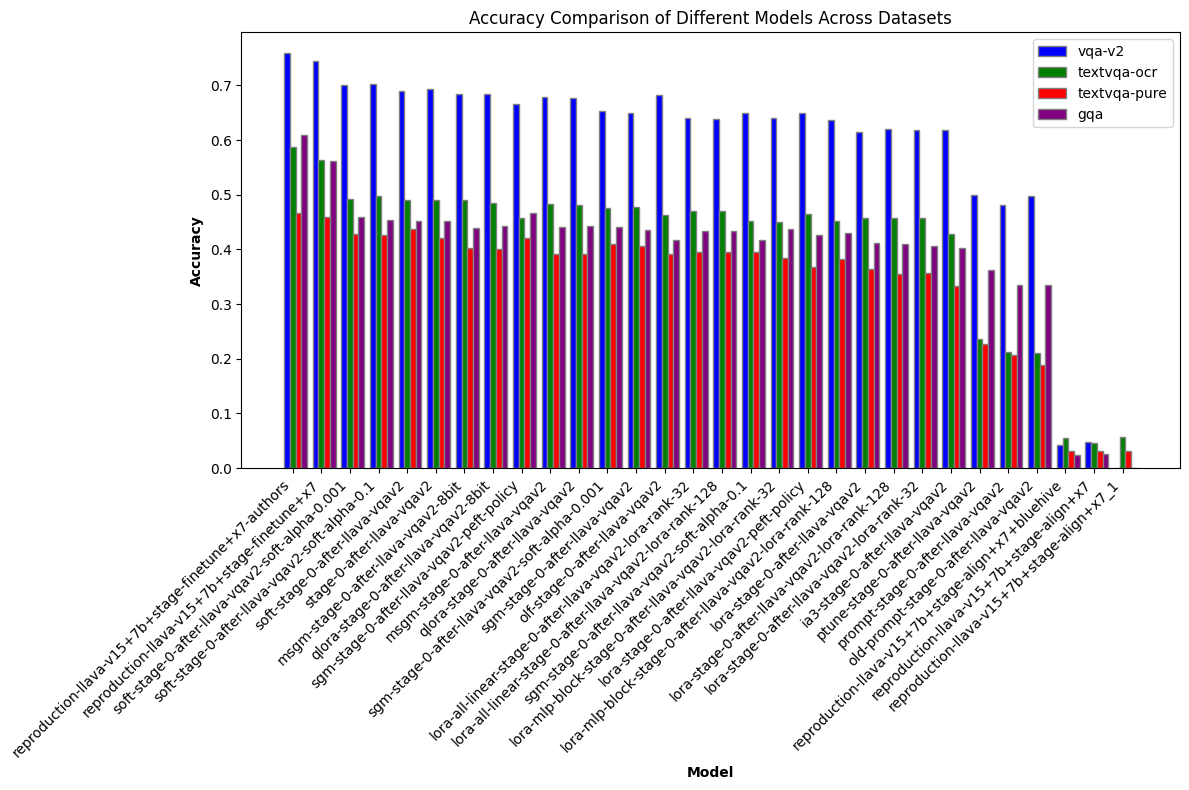

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the combined JSON data
combined_file = 'combined_results.json'

with open(combined_file, 'r') as f:
    combined_results = json.load(f)

# Extract data for calculating average accuracy and sorting
model_accuracies = []

for model_name, metrics in combined_results.items():
    accuracies = [
        metrics.get('vqa-v2', np.nan),
        metrics.get('textvqa-ocr', np.nan),
        metrics.get('textvqa-pure', np.nan),
        metrics.get('gqa', np.nan)
    ]
    # Calculate average accuracy, ignoring NaN values
    avg_accuracy = np.nanmean(accuracies)
    model_accuracies.append((model_name, accuracies, avg_accuracy))

# Sort models based on average accuracy
model_accuracies.sort(key=lambda x: x[2], reverse=True)

# Extract sorted data for plotting
models = [x[0] for x in model_accuracies]
vqa_v2_accuracies = [x[1][0] for x in model_accuracies]
textvqa_ocr_accuracies = [x[1][1] for x in model_accuracies]
textvqa_pure_accuracies = [x[1][2] for x in model_accuracies]
gqa_accuracies = [x[1][3] for x in model_accuracies]

# Define the bar width
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.figure(figsize=(12, 8))

# Create bars
plt.bar(r1, vqa_v2_accuracies, color='blue', width=bar_width, edgecolor='grey', label='vqa-v2')
plt.bar(r2, textvqa_ocr_accuracies, color='green', width=bar_width, edgecolor='grey', label='textvqa-ocr')
plt.bar(r3, textvqa_pure_accuracies, color='red', width=bar_width, edgecolor='grey', label='textvqa-pure')
plt.bar(r4, gqa_accuracies, color='purple', width=bar_width, edgecolor='grey', label='gqa')

# Add xticks on the middle of the group bars
plt.xlabel('Model', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(models))], models, rotation=45, ha='right')

# Add labels
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy Comparison of Different Models Across Datasets')

# Create legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [26]:
import json
import numpy as np

# Define the input file name and load the combined JSON data
combined_file = 'combined_results.json'

with open(combined_file, 'r') as f:
    combined_results = json.load(f)

# Define the list of models and the rules for matching
models = ['soft', 'lora', 'qlora', 'msgm', 'sgm', 'ptune', 'prompt', 'ia3', 'naive-ft', 'llm']
model_mappings = {
    'soft': [],
    'lora': [],
    'qlora': [],
    'msgm': [],
    'sgm': [],
    'ptune': [],
    'prompt': [],
    'ia3': [],
    'naive-ft': []
}

# Populate the mappings based on model name rules
for model_name, metrics in combined_results.items():
    for model in models:
        if model in ['msgm', 'sgm'] and (model in model_name or 'msgm' in model_name or 'sgm' in model_name):
            model_mappings['msgm'].append((model_name, np.nanmean(list(metrics.values()))))
            model_mappings['sgm'].append((model_name, np.nanmean(list(metrics.values()))))
        elif model == 'naive-ft' and model_name.startswith('stage'):
            model_mappings['naive-ft'].append((model_name, np.nanmean(list(metrics.values()))))
        elif model in model_name:
            model_mappings[model].append((model_name, np.nanmean(list(metrics.values()))))

# Identify the highest accuracy model for each mapping
highest_accuracy_models = {}
for model, mappings in model_mappings.items():
    if mappings:
        highest_accuracy_models[model] = max(mappings, key=lambda x: x[1])

# Output the highest accuracy mappings
for model, (model_name, accuracy) in highest_accuracy_models.items():
    print(f"Model: {model}, Highest Accuracy Model: {model_name}, Accuracy: {accuracy}")

# Save the result to a file
output_file = 'highest_accuracy_models.json'
with open(output_file, 'w') as f:
    json.dump(highest_accuracy_models, f, indent=2)

print(f"Highest accuracy models saved to {output_file}")


Model: soft, Highest Accuracy Model: soft-stage-0-after-llava-vqav2-soft-alpha-0.001, Accuracy: 0.52025
Model: lora, Highest Accuracy Model: qlora-stage-0-after-llava-vqav2-8bit, Accuracy: 0.50275
Model: qlora, Highest Accuracy Model: qlora-stage-0-after-llava-vqav2-8bit, Accuracy: 0.50275
Model: msgm, Highest Accuracy Model: msgm-stage-0-after-llava-vqav2-8bit, Accuracy: 0.504
Model: sgm, Highest Accuracy Model: msgm-stage-0-after-llava-vqav2-8bit, Accuracy: 0.504
Model: ptune, Highest Accuracy Model: ptune-stage-0-after-llava-vqav2, Accuracy: 0.33099999999999996
Model: prompt, Highest Accuracy Model: prompt-stage-0-after-llava-vqav2, Accuracy: 0.3085
Model: ia3, Highest Accuracy Model: ia3-stage-0-after-llava-vqav2, Accuracy: 0.446
Model: naive-ft, Highest Accuracy Model: stage-0-after-llava-vqav2, Accuracy: 0.514
Highest accuracy models saved to highest_accuracy_models.json


In [31]:
import json
import numpy as np

# Define the input file names and load the combined JSON data
combined_file = 'combined_results.json'
highest_accuracy_file = 'highest_accuracy_models.json'

with open(combined_file, 'r') as f:
    combined_results = json.load(f)

# Define the list of models and the rules for matching
models = ['soft', 'lora', 'qlora', 'msgm', 'sgm', 'ptune', 'prompt', 'ia3', 'naive-ft']
model_mappings = {model: [] for model in models}

# Function to map model_name to category
def get_category(model_name):
    if model_name.startswith('stage'):
        return 'naive-ft'
    for model in models:
        if model in ['msgm', 'sgm']:
            if 'msgm' in model_name or 'sgm' in model_name:
                return 'msgm'
        elif model in model_name:
            return model
    return None

# Populate the mappings based on model name rules
for model_name, metrics in combined_results.items():
    category = get_category(model_name)
    if category:
        accuracies = list(metrics.values())
        avg_accuracy = np.nanmean(accuracies)
        model_mappings[category].append((model_name, avg_accuracy))

# Identify the highest accuracy model for each mapping
highest_accuracy_models = {}
for model, mappings in model_mappings.items():
    if mappings:
        highest_accuracy_models[model] = max(mappings, key=lambda x: x[1])

# Save the highest accuracy models to a file
output_file = 'highest_accuracy_models.json'
with open(output_file, 'w') as f:
    json.dump(highest_accuracy_models, f, indent=2)

# Map the highest accuracy models to the new names
name_mapping = {
    'soft': 'Soft Targets',
    'msgm': 'mSGM',
    'sgm': 'mSGM',
    'lora': 'LoRA',
    'qlora': 'QLoRA',
    'ia3': 'IA3',
    'prompt': 'Prompt Tuning',
    'ptune': 'P-Tuning',
    'naive-ft': 'LLaVA Naive-FT'
}

# Prepare data for radar chart
datasets = ['vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa']
methods = [name_mapping[model] for model in models if model in highest_accuracy_models]
results_dict = {}

for model in models:
    if model in highest_accuracy_models:
        model_name, _ = highest_accuracy_models[model]
        metrics = combined_results[model_name]
        accuracies = {
            'vqa-v2': metrics.get('vqa-v2', np.nan),
            'textvqa-ocr': metrics.get('textvqa-ocr', np.nan),
            'textvqa-pure': metrics.get('textvqa-pure', np.nan),
            'gqa': metrics.get('gqa', np.nan)
        }
        results_dict[name_mapping[model]] = accuracies

# Output the results dictionary
print(json.dumps(results_dict, indent=2))


{
  "Soft Targets": {
    "vqa-v2": 0.7,
    "textvqa-ocr": 0.493,
    "textvqa-pure": 0.428,
    "gqa": 0.46
  },
  "LoRA": {
    "vqa-v2": 0.684,
    "textvqa-ocr": 0.484,
    "textvqa-pure": 0.401,
    "gqa": 0.442
  },
  "mSGM": {
    "vqa-v2": 0.684,
    "textvqa-ocr": 0.491,
    "textvqa-pure": 0.402,
    "gqa": 0.439
  },
  "P-Tuning": {
    "vqa-v2": 0.499,
    "textvqa-ocr": 0.236,
    "textvqa-pure": 0.226,
    "gqa": 0.363
  },
  "Prompt Tuning": {
    "vqa-v2": 0.481,
    "textvqa-ocr": 0.213,
    "textvqa-pure": 0.206,
    "gqa": 0.334
  },
  "IA3": {
    "vqa-v2": 0.619,
    "textvqa-ocr": 0.429,
    "textvqa-pure": 0.333,
    "gqa": 0.403
  },
  "LLaVA Naive-FT": {
    "vqa-v2": 0.693,
    "textvqa-ocr": 0.491,
    "textvqa-pure": 0.421,
    "gqa": 0.451
  }
}


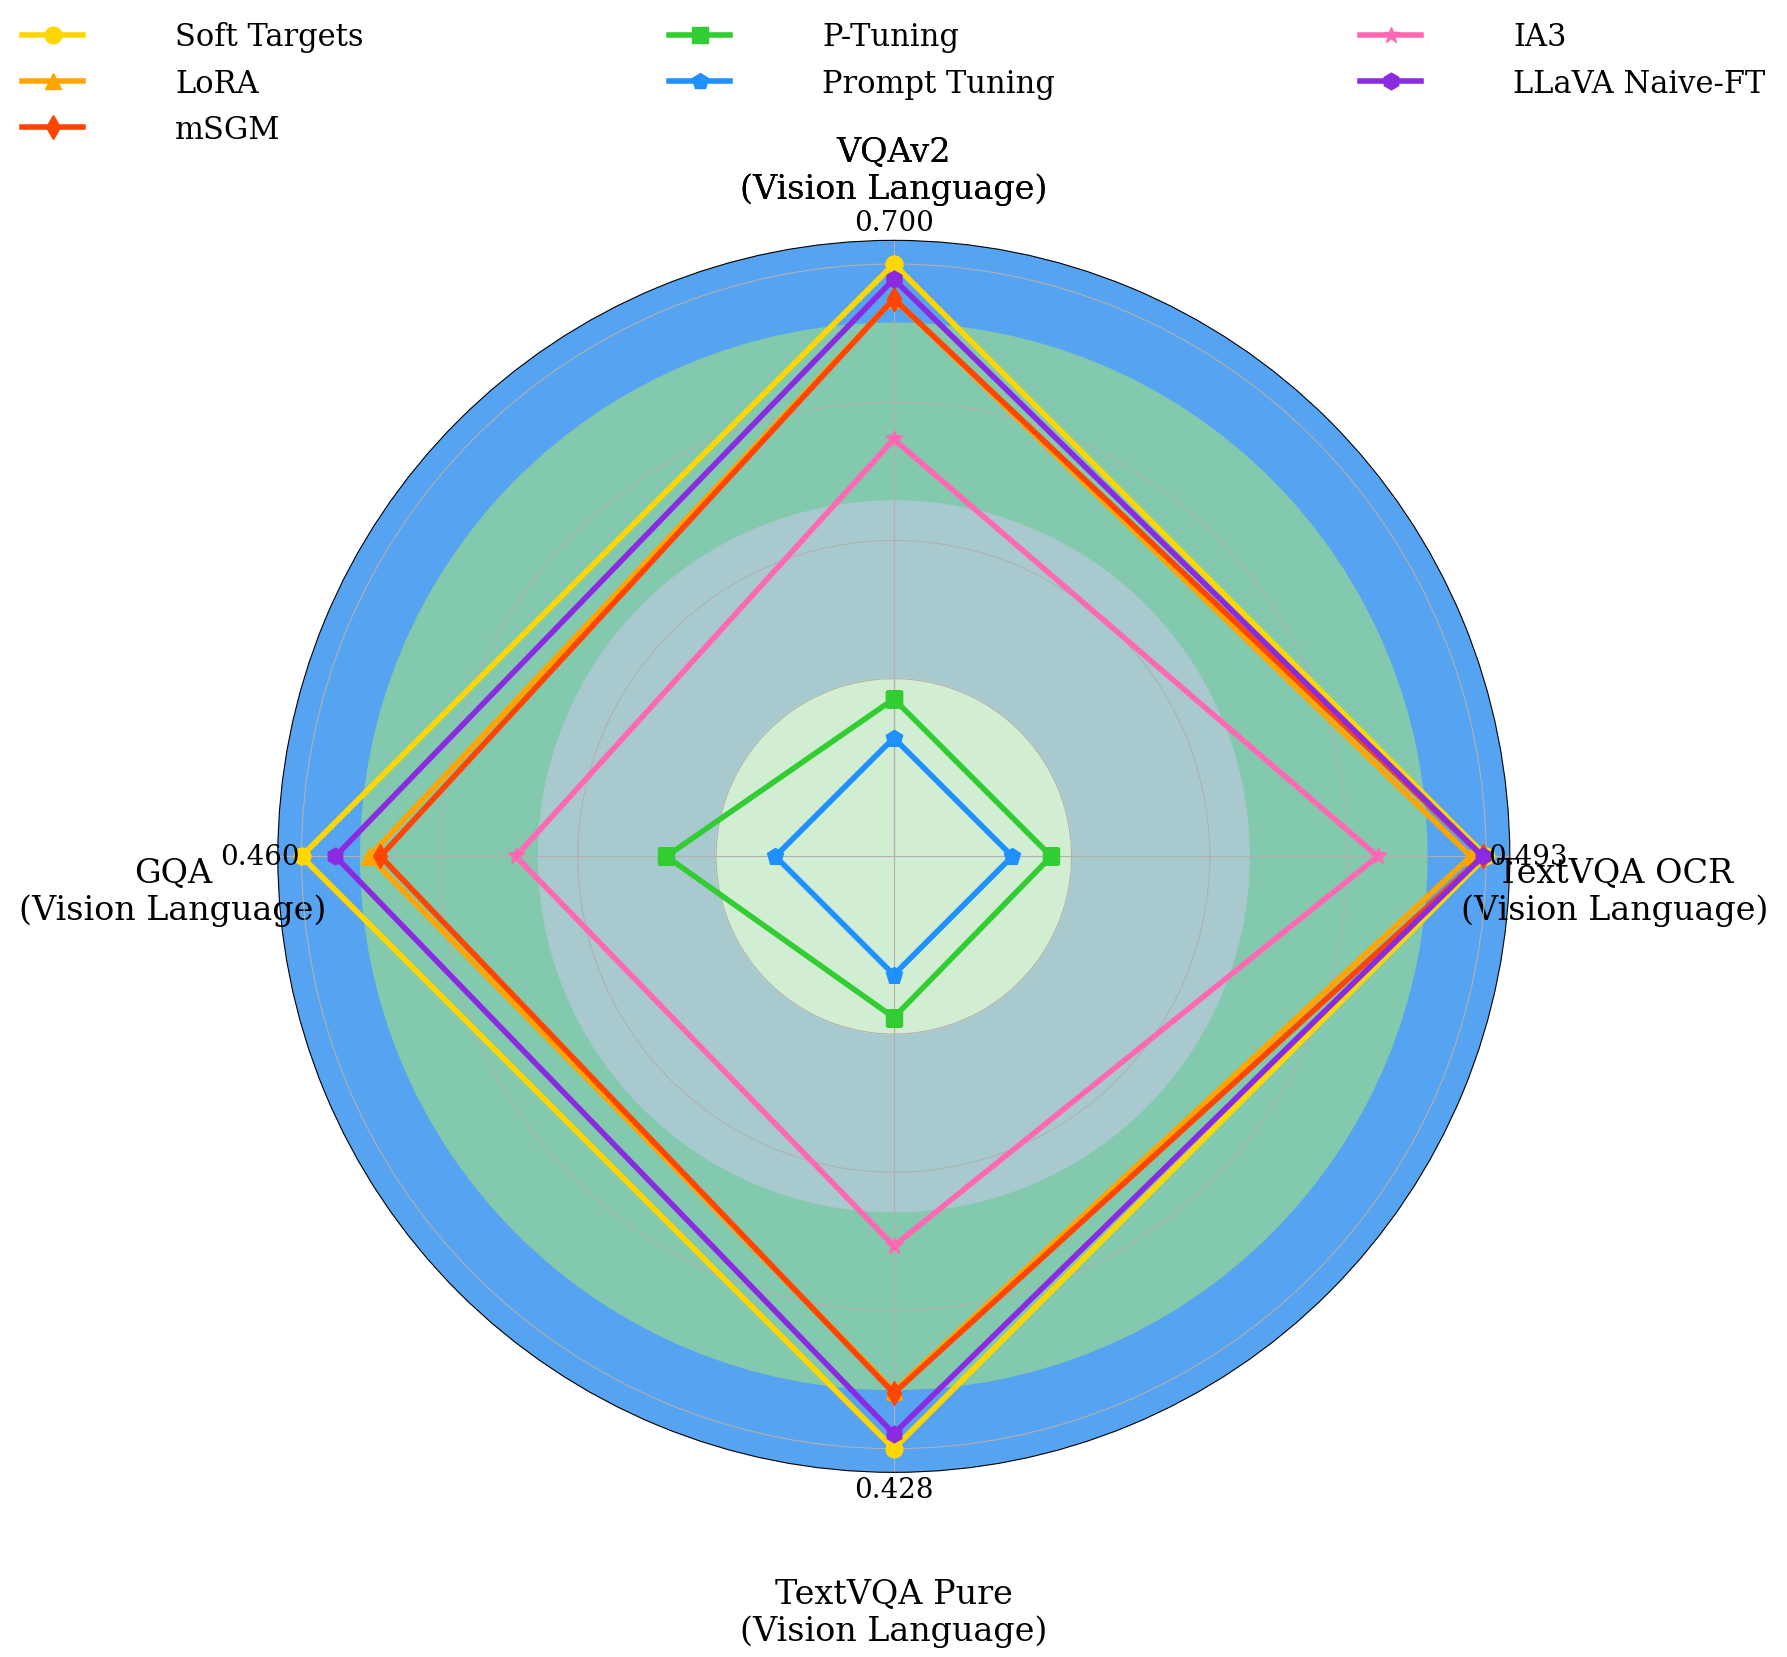

In [32]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for radar chart
datasets = ['vqa-v2', 'textvqa-ocr', 'textvqa-pure', 'gqa']
methods = list(results_dict.keys())
results = []

for method in methods:
    accuracies = [results_dict[method][dataset] for dataset in datasets]
    results.append(accuracies)

# Convert to numpy array
results = np.array(results)

# Normalize the values for the plot
def normalize_values(values, min_val=0.2, max_val=1.0):
    norm_values = np.zeros_like(values)
    for i in range(values.shape[1]):
        col_min = np.nanmin(values[:, i])
        col_max = np.nanmax(values[:, i])
        norm_values[:, i] = (values[:, i] - col_min) / (col_max - col_min) * (max_val - min_val) + min_val
    return norm_values

plot_results = normalize_values(results)

# Close the loop for the radar chart
methods.append(methods[0])
plot_results = np.concatenate((plot_results, plot_results[:, [0]]), axis=1)
results = np.concatenate((results, results[:, [0]]), axis=1)

# Custom labels with line breaks
labels = ['VQAv2\n(Vision Language)', 'TextVQA OCR\n(Vision Language)', 'TextVQA Pure\n(Vision Language)', 'GQA\n(Vision Language)', 'VQAv2\n(Vision Language)']

fig, ax = plt.subplots(figsize=(16, 16), subplot_kw=dict(polar=True))
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(labels))

# Radar lines
linestyles = ["solid", "solid", "solid", "solid", "solid", "solid", "solid", "solid"]
markers = ["o", "^", "d", "s", "p", "*", "h", "x"]
colors = ["#FFD700", "#FFA500", "#FF4500", "#32CD32", "#1E90FF", "#FF69B4", "#8A2BE2", "#A52A2A"]

for res_ix, res in enumerate(plot_results):
    ax.plot(label_loc, res, lw=4, ls=linestyles[res_ix], marker=markers[res_ix], markersize=12, label=methods[res_ix], color=colors[res_ix])

# VQAv2 at the top, remaining metrics are added in a clockwise direction
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# Concentric circles
thickness = 0.3
colors_circles = ["#D1EDD2", "#A8CACE", "#83C9AD", "#56A3F1"]
ax.set_rticks(np.linspace(thickness, 1.0, len(colors_circles)))
ax.set_yticklabels([])
for ix in range(len(colors_circles), 0, -1):
    circ = plt.Circle((0, 0), ix * thickness, transform=ax.transData._b, color=colors_circles[ix - 1])
    ax.add_artist(circ)

# Increase font size for readability and spacing of labels
plt.rc('font', family='serif', size=22)          # controls default text sizes
plt.rc('axes', titlesize=30)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=34)   # fontsize of the figure title

# Apply the larger font size to the labels and space them out
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=labels, fontsize=24, verticalalignment='top')
ax.tick_params(pad=65)  # Increase padding to space the labels further from the chart

# Annotate the axes with the true accuracy values
for i, label in enumerate(labels[:-1]):  # Exclude the last label which is a duplicate
    angle_rad = label_loc[i]
    angle_deg = np.degrees(angle_rad)
    ha = 'center'
    if angle_deg > 90 and angle_deg < 270:
        angle_deg = angle_deg + 180
        ha = 'center'
    ax.text(angle_rad, 1.07, f"{np.nanmax(results[:, i]):.3f}", size=20, horizontalalignment=ha, verticalalignment='center')

# Adding legend at the top, horizontal, and spaced out
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False, handletextpad=3, columnspacing=10)

# Save the plot as SVG
plt.savefig('radar_chart.svg', format='svg')

plt.show()


In [33]:
import json

# Calculate delta values
naive_ft_acc = results_dict["LLaVA Naive-FT"]
table_data = []

for model, accuracies in results_dict.items():
    if model == "LLaVA Naive-FT":
        continue
    deltas = {dataset: naive_ft_acc[dataset] - acc for dataset, acc in accuracies.items()}
    avg_delta = sum(deltas.values()) / len(deltas)
    avg_acc = sum(accuracies.values()) / len(accuracies)
    table_data.append((model, accuracies, deltas, avg_delta, avg_acc))

# Sort the data so LLaVA Naive-FT is first
table_data = sorted(table_data, key=lambda x: x[3])

# Generate LaTeX table
latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{LLaVA Model Performance:} Task-wise Accuracies of Each Mitigation Method across Vision-Language (VL) tasks}
  \\label{tab:vl_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cccc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{4}{c|}{\\textbf{Vision-Language (VL)}} & \\multicolumn{2}{c}{\\textbf{VL Avg.}} \\\\
     & {VQAv2} & {TextVQA OCR} & {TextVQA Pure} & {GQA} & $\\Delta$ & Acc \\\\
     \\midrule
"""
latex_code += "LLaVA Naive-FT & {vqa_v2:.3f} & {textvqa_ocr:.3f} & {textvqa_pure:.3f} & {gqa:.3f} & - & {avg_acc:.3f} \\\\\n".format(
    vqa_v2=naive_ft_acc["vqa-v2"],
    textvqa_ocr=naive_ft_acc["textvqa-ocr"],
    textvqa_pure=naive_ft_acc["textvqa-pure"],
    gqa=naive_ft_acc["gqa"],
    avg_acc=sum(naive_ft_acc.values()) / len(naive_ft_acc)
)
latex_code += "\\midrule\n"

for model, accuracies, deltas, avg_delta, avg_acc in table_data:
    latex_code += "{model} & {vqa_v2:.3f} & {textvqa_ocr:.3f} & {textvqa_pure:.3f} & {gqa:.3f} & {delta:.3f} & {acc:.3f} \\\\\n".format(
        model=model,
        vqa_v2=accuracies["vqa-v2"],
        textvqa_ocr=accuracies["textvqa-ocr"],
        textvqa_pure=accuracies["textvqa-pure"],
        gqa=accuracies["gqa"],
        delta=avg_delta,
        acc=avg_acc
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)



\begin{table*}[h]
  \caption{\textbf{LLaVA Model Performance:} Task-wise Accuracies of Each Mitigation Method across Vision-Language (VL) tasks}
  \label{tab:vl_acc}
  \centering
  \resizebox{\linewidth}{!}{
    \begin{tabular}{l|cccc|cc}
     \toprule
     \textbf{Model} & \multicolumn{4}{c|}{\textbf{Vision-Language (VL)}} & \multicolumn{2}{c}{\textbf{VL Avg.}} \\
     & {VQAv2} & {TextVQA OCR} & {TextVQA Pure} & {GQA} & $\Delta$ & Acc \\
     \midrule
LLaVA Naive-FT & 0.693 & 0.491 & 0.421 & 0.451 & - & 0.514 \\
\midrule
Soft Targets & 0.700 & 0.493 & 0.428 & 0.460 & -0.006 & 0.520 \\
mSGM & 0.684 & 0.491 & 0.402 & 0.439 & 0.010 & 0.504 \\
LoRA & 0.684 & 0.484 & 0.401 & 0.442 & 0.011 & 0.503 \\
IA3 & 0.619 & 0.429 & 0.333 & 0.403 & 0.068 & 0.446 \\
P-Tuning & 0.499 & 0.236 & 0.226 & 0.363 & 0.183 & 0.331 \\
Prompt Tuning & 0.481 & 0.213 & 0.206 & 0.334 & 0.205 & 0.308 \\

     \bottomrule
    \end{tabular}
  }
\end{table*}



In [34]:
import json

# Calculate delta values
naive_ft_acc = results_dict["LLaVA Naive-FT"]
table_data = []

for model, accuracies in results_dict.items():
    if model == "LLaVA Naive-FT":
        continue
    deltas = {dataset: naive_ft_acc[dataset] - acc for dataset, acc in accuracies.items()}
    avg_delta = sum(deltas.values()) / len(deltas)
    avg_acc = sum(accuracies.values()) / len(accuracies)
    table_data.append((model, accuracies, deltas, avg_delta, avg_acc))

# Sort the data so LLaVA Naive-FT is first
table_data = sorted(table_data, key=lambda x: x[3])

# Generate LaTeX table
latex_code = """
\\begin{table*}[h]
  \\caption{\\textbf{LLaVA Model Performance:} Task-wise Accuracies of Each Mitigation Method across Vision-Language (VL) tasks}
  \\label{tab:vl_acc}
  \\centering
  \\resizebox{\\linewidth}{!}{
    \\begin{tabular}{l|cccc|cc}
     \\toprule
     \\textbf{Model} & \\multicolumn{4}{c|}{\\textbf{Vision-Language (VL)}} & \\multicolumn{2}{c}{\\textbf{VL Avg.}} \\\\
     & \\textbf{VQAv2} & \\textbf{TextVQA OCR} & \\textbf{TextVQA Pure} & \\textbf{GQA} & $\\Delta$ & Acc \\\\
     \\midrule
"""
latex_code += "LLaVA Naive-FT & {vqa_v2:.3f} & {textvqa_ocr:.3f} & {textvqa_pure:.3f} & {gqa:.3f} & - & {avg_acc:.3f} \\\\\n".format(
    vqa_v2=naive_ft_acc["vqa-v2"],
    textvqa_ocr=naive_ft_acc["textvqa-ocr"],
    textvqa_pure=naive_ft_acc["textvqa-pure"],
    gqa=naive_ft_acc["gqa"],
    avg_acc=sum(naive_ft_acc.values()) / len(naive_ft_acc)
)
latex_code += "Vicuna 1.5 7B & - & - & - & - & - & - \\\\\n"
latex_code += "\\midrule\n"

for model, accuracies, deltas, avg_delta, avg_acc in table_data:
    latex_code += "{model} & {vqa_v2:.3f} & {textvqa_ocr:.3f} & {textvqa_pure:.3f} & {gqa:.3f} & {delta:.3f} & {acc:.3f} \\\\\n".format(
        model=model,
        vqa_v2=accuracies["vqa-v2"],
        textvqa_ocr=accuracies["textvqa-ocr"],
        textvqa_pure=accuracies["textvqa-pure"],
        gqa=accuracies["gqa"],
        delta=avg_delta,
        acc=avg_acc
    )

latex_code += """
     \\bottomrule
    \\end{tabular}
  }
\\end{table*}
"""

print(latex_code)



\begin{table*}[h]
  \caption{\textbf{LLaVA Model Performance:} Task-wise Accuracies of Each Mitigation Method across Vision-Language (VL) tasks}
  \label{tab:vl_acc}
  \centering
  \resizebox{\linewidth}{!}{
    \begin{tabular}{l|cccc|cc}
     \toprule
     \textbf{Model} & \multicolumn{4}{c|}{\textbf{Vision-Language (VL)}} & \multicolumn{2}{c}{\textbf{VL Avg.}} \\
     & \textbf{VQAv2} & \textbf{TextVQA OCR} & \textbf{TextVQA Pure} & \textbf{GQA} & $\Delta$ & Acc \\
     \midrule
LLaVA Naive-FT & 0.693 & 0.491 & 0.421 & 0.451 & - & 0.514 \\
Vicuna 1.5 7B & - & - & - & - & - & - \\
\midrule
Soft Targets & 0.700 & 0.493 & 0.428 & 0.460 & -0.006 & 0.520 \\
mSGM & 0.684 & 0.491 & 0.402 & 0.439 & 0.010 & 0.504 \\
LoRA & 0.684 & 0.484 & 0.401 & 0.442 & 0.011 & 0.503 \\
IA3 & 0.619 & 0.429 & 0.333 & 0.403 & 0.068 & 0.446 \\
P-Tuning & 0.499 & 0.236 & 0.226 & 0.363 & 0.183 & 0.331 \\
Prompt Tuning & 0.481 & 0.213 & 0.206 & 0.334 & 0.205 & 0.308 \\

     \bottomrule
    \end{tabular}
  }
\end